# Описание проекта
Маркетинговая аналитика развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

<b>Цель исследования:</b> 

1.Определить окупаемость рекламных компаний.

2.Выделить причины неэффективности привлечения пользователей.

3.Предложить рекомендации для отдела маркетинга.

<b>Ход исследования:</b> 

- Данные получим из предоставленных файлов `visits_info_short.csv`, `orders_info_short.csv` и `costs_info_short.csv`. Перед проведением исследования необходимо данные осмотреть на предмет пропусков, аномалий и структуры в целом.

Исследование будем проводить в 7 этапов:

- Обзор данных

- Предобработка и подготовка данных к анализу

- Зададим функции для расчета необходимых метрик и построения графиков

- Составим профилей пользователей. Определим страны, устройства и источники привлечения для пользователей, расчитаем `CR`

- Посчитаем сумму расходов на маркетинг и `САС` в целом и на каждый канал в отдельности

- Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 

- Напишем общий вывод.

# Описание данных

В нащем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:

`User Id` — уникальный идентификатор пользователя,

`Region` — страна пользователя,

`Device` — тип устройства пользователя,

`Channel` — идентификатор источника перехода,

`Session Start` — дата и время начала сессии,

`Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:

`User Id` — уникальный идентификатор пользователя,
`Event Dt` — дата и время покупки,
`Revenue` — сумма заказа.

Структура `costs_info_short.csv`:

`dt` — дата проведения рекламной кампании,

`Channel` — идентификатор рекламного источника,

`costs` — расходы на эту кампанию.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Загрузим и сразу посмотрим на файлы с данными.

In [2]:
try:
    visits, orders, costs = (
    pd.read_csv('C:/Users/ACER/Desktop/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('C:/Users/ACER/Desktop/orders_info_short.csv'),  # покупки
    pd.read_csv('C:/Users/ACER/Desktop/costs_info_short.csv')  # траты на рекламу
)
except:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv')  # траты на рекламу
)

In [3]:
print(visits.info())
print('Пропусков: ', visits.isna().sum())
print('Дубликатов: ',visits.duplicated().sum())
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Пропусков:  User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
Дубликатов:  0


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


В файле `visits` нет пропусков и явных дубликатов. Необходимо столбцы `Session Start` и `Session End` привести к типу datetime64. Весь датасет привести к зменому регистру.

In [4]:
print(orders.info())
print('Пропусков: ', orders.isna().sum())
print('Дубликатов: ',orders.duplicated().sum())
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Пропусков:  User Id     0
Event Dt    0
Revenue     0
dtype: int64
Дубликатов:  0


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


В файле `orders` нет пропусков и явных дубликатов. Необходимо столбец `Event Dt` привести к типу datetime64. Весь датасет привести к зменому регистру.

In [5]:
print(costs.info())
print('Пропусков: ', costs.isna().sum())
print('Дубликатов: ',costs.duplicated().sum())
costs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Пропусков:  dt         0
Channel    0
costs      0
dtype: int64
Дубликатов:  0


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


В файле `costs` нет пропусков и явных дубликатов. Необходимо столбец `dt` привести к типу datetime64. Весь датасет привести к зменому регистру.

Проиведем описанные преобразования.

In [6]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.columns = visits.columns.str.lower()
visits['region'] = visits['region'].str.lower()
visits['device'] = visits['device'].str.lower()
visits['channel'] = visits['channel'].str.lower()
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.head(5)

,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [7]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.head(5)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [8]:
costs.columns = costs.columns.str.lower()
costs['channel'] = costs['channel'].str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.head(5)

,dt,channel,costs
0,2019-05-01,faceboom,113.30
1,2019-05-02,faceboom,78.10
2,2019-05-03,faceboom,85.80
3,2019-05-04,faceboom,136.40
4,2019-05-05,faceboom,122.10


В исходных данных нет пропусков и дубликатов. Мы отработали необходимость изменить типы данных в столбцах с датами, а также исправить регистр. В целом, качество данных удовлетворяет нашим целям.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Зададим функции

In [9]:
events = None # события отсутствуют

# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

•	Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [17]:
profiles = get_profiles(visits, orders, events, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.23


In [18]:
# определим минимальную и максимальную даты привлечения пользователей:
print('Минимальная дата:', profiles['first_ts'].min())
print('Максимальная дата:',profiles['first_ts'].max())

Минимальная дата: 2019-05-01 00:00:41
Максимальная дата: 2019-10-27 23:59:04


Минимальная дата привлечения 1 мая 2019 г. нас полностью устраивает, а вот максимальная 27 октября 2019 г. уже заходит за нужный нам горизонт анализа. По ТЗ нас интересуют пользователи с лайфтаймом в 14 дней, поэтому пользователи привлеченные после 18 октября нам уже не подходят, т.к. не успели "прожить" необходимый срок.

- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
- Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
region = pd.pivot_table(profiles, columns='region', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
region

,user_id
region,
united states,100002
uk,17575
france,17450
germany,14981


Больше всего пользователей приходят из США, меньше всего - из Германии.

In [20]:
region_payers = pd.pivot_table(profiles.query('payer == True'), columns='region', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
region_payers

,user_id
region,
united states,6902
uk,700
france,663
germany,616


С платящими пользователями ситуация не отличается.

In [21]:
region_payers=region_payers.merge(region, on = 'region')
region_payers.rename(columns={'user_id_x': 'payers'}, inplace=True)
region_payers.rename(columns={'user_id_y': 'clients'}, inplace=True)
region_payers['%_of_payers'] = region_payers['payers'] / region_payers['clients'] * 100
region_payers.sort_values(by='%_of_payers',ascending=False)

,payers,clients,%_of_payers
region,,,
united states,6902,100002,6.90
germany,616,14981,4.11
uk,700,17575,3.98
france,663,17450,3.80


В процентном отношении платящих к неплатящим пользователям всё также выигрывают пользователи из США. А вот Германия теперь на втором месте.

- Посмотрим какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
- Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [22]:
device = pd.pivot_table(profiles, columns='device', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
device

,user_id
device,
iphone,54479
android,35032
pc,30455
mac,30042


Больше всего пользователей заходят в приложения с Iphone, меньше всего c Mac.

In [23]:
device_payers = pd.pivot_table(profiles.query('payer == True'), columns='device', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
device_payers

,user_id
device,
iphone,3382
android,2050
mac,1912
pc,1537


Наибольшее число платящих полльзователей также пользуются Айфонами. 

In [24]:
device_payers=device_payers.merge(device, on = 'device')
device_payers.rename(columns={'user_id_x': 'payers'}, inplace=True)
device_payers.rename(columns={'user_id_y': 'clients'}, inplace=True)
device_payers['%_of_payers'] =device_payers['payers'] / device_payers['clients'] * 100
device_payers.sort_values(by='%_of_payers',ascending=False)

,payers,clients,%_of_payers
device,,,
mac,1912,30042,6.36
iphone,3382,54479,6.21
android,2050,35032,5.85
pc,1537,30455,5.05


А вот в процентном отношении самыми "щедрыми" оказались владельцы Mac. Пользователи ПК наименее склонны к покупкам в приложении.

- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 
- Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [25]:
channel = pd.pivot_table(profiles, columns='channel', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
channel

,user_id
channel,
organic,56439
faceboom,29144
tiptop,19561
opplecreativemedia,8605
leapbob,8553
wahoonetbanner,8553
rocketsuperads,4448
mediatornado,4364
yrabbit,4312


Больше всего пользователей пришли в приложение самостоятельно, без помощи рекламы. Среди рекламных площадок первое место занимает "Faceboom", последнее - "LambdaMediaAds"

In [26]:
channel_payers = pd.pivot_table(profiles.query('payer == True'), columns='channel', values = 'user_id', aggfunc='count').T\
.sort_values(by='user_id',ascending=False)
channel_payers

,user_id
channel,
faceboom,3557
tiptop,1878
organic,1160
wahoonetbanner,453
adnonsense,440
rocketsuperads,352
leapbob,262
opplecreativemedia,233
lambdamediaads,225


Первенство по числу платящих пользователей держат те же рекламные сети, что и по кол-ву привлеченных. 

In [27]:
channel_payers=channel_payers.merge(channel, on = 'channel')
channel_payers.rename(columns={'user_id_x': 'payers'}, inplace=True)
channel_payers.rename(columns={'user_id_y': 'clients'}, inplace=True)
channel_payers['%_of_payers'] =channel_payers['payers'] / channel_payers['clients'] * 100
channel_payers.sort_values(by='%_of_payers',ascending=False)

,payers,clients,%_of_payers
channel,,,
faceboom,3557,29144,12.20
adnonsense,440,3880,11.34
lambdamediaads,225,2149,10.47
tiptop,1878,19561,9.60
rocketsuperads,352,4448,7.91
wahoonetbanner,453,8553,5.30
yrabbit,165,4312,3.83
mediatornado,156,4364,3.57
leapbob,262,8553,3.06


Faceboom берет не только количеством, но и качеством - самая большая доля платящих пользователей среди привлеченных. LambdaMediaAds хоть и привлекли наименьшее число пользователей, но сделали это на совесть и занимают почетное третье место в соревнованиях по конверсии. Ну а органики, ожидаемо, завершают список.

<b>Как итог,</b> видим, что основной рынок для компании это США. 

Чаще всего продукт интересует владельцев Iphone,  но процент платящих пользователей выше среди владельцев Mac. 

По числу привлеченных пользователей среди рекламных площадок первое место занимает "Faceboom", последнее - "LambdaMediaAds". По конвертируемости привлеченных пользователей также лидирует Faceboom.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.

In [28]:
print('Общая сумма расходов составила: ',costs['costs'].sum().round(1))

Общая сумма расходов составила:  105497.3


Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [29]:
costs_by_channel = pd.pivot_table(costs, index = 'channel', values = 'costs', aggfunc=sum)\
.sort_values(by = 'costs', ascending=False)
costs_by_channel

,costs
channel,
tiptop,"54,751.30"
faceboom,"32,445.60"
wahoonetbanner,"5,151.00"
adnonsense,"3,911.25"
opplecreativemedia,"2,151.25"
rocketsuperads,"1,833.00"
leapbob,"1,797.60"
lambdamediaads,"1,557.60"
mediatornado,954.48


Самые высокие расходы на рекламу в TipTop, а они даже не в тройке лидеров по конвертируемости приведенных пользователей.

- Построим визуализацию динамики изменения расходов во времени (по неделям) по каждому источнику. 

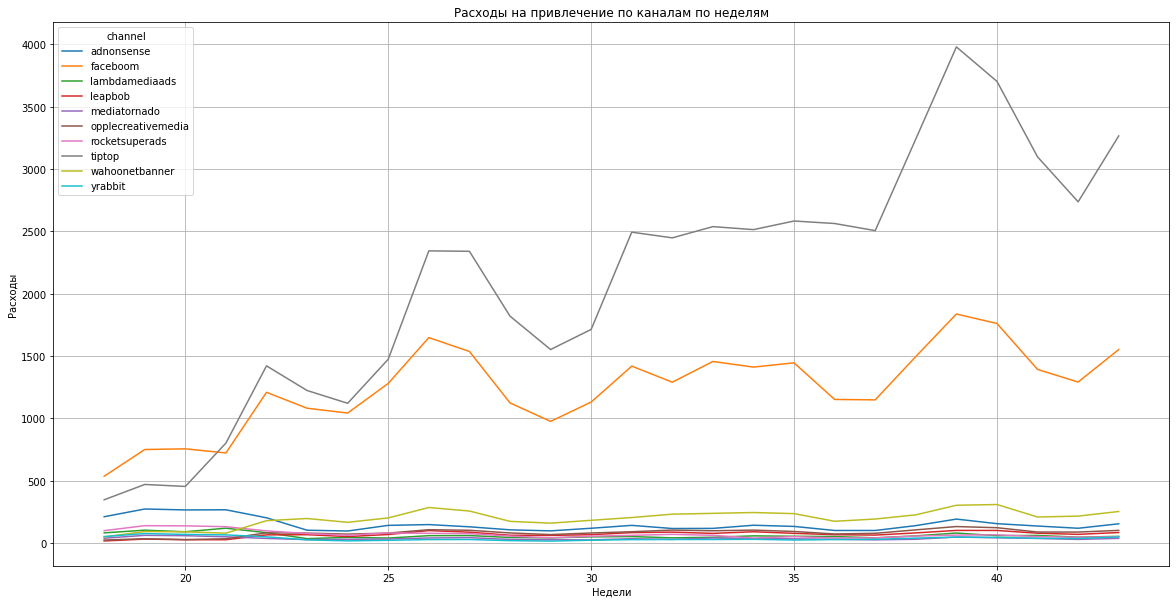

In [30]:
costs['month'] =  pd.to_datetime(costs["dt"]).dt.month #получаем номер недели
costs['week'] =  pd.to_datetime(costs["dt"]).dt.isocalendar().week #получаем номер недели
costs_pivot_w = pd.pivot_table(costs, index = 'week', columns='channel', values = 'costs', aggfunc=sum).plot(grid = True, figsize = (20,10))
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по каналам по неделям')
plt.show()

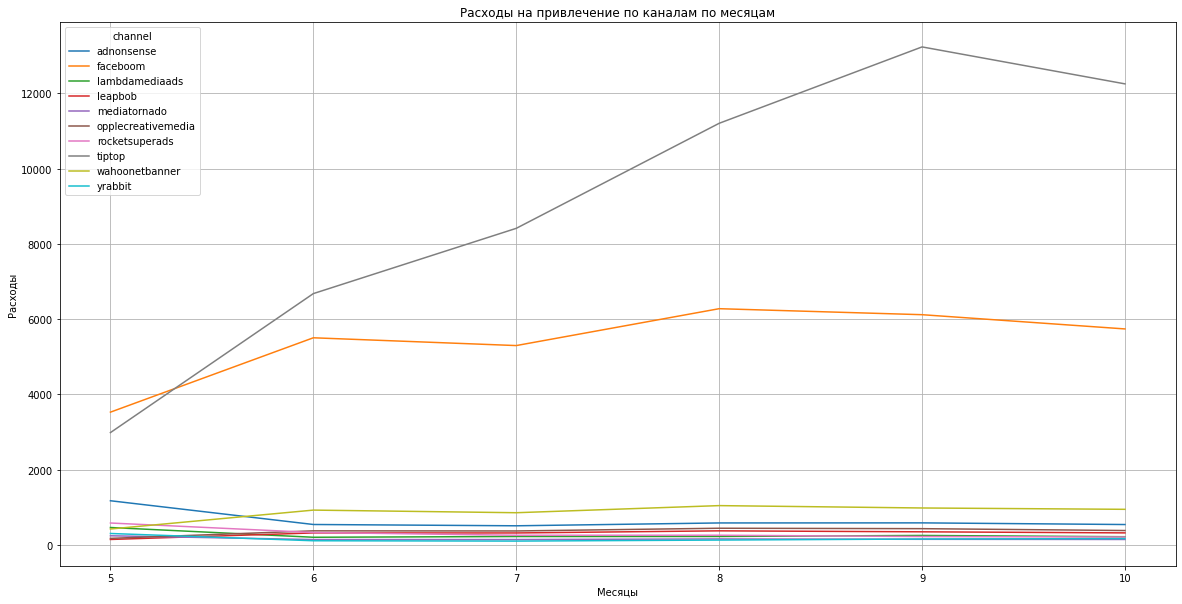

In [31]:
costs_pivot_m = pd.pivot_table(costs, index = 'month', columns='channel', values = 'costs', aggfunc=sum).plot(grid = True, figsize = (20,10))
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по каналам по месяцам')
plt.show()

Расходы на TipTop самые высокие и неуклонно растут. Судя по ранее полученным данным это не самое выгодное вложение. Значительную часть расходов таже получает Faceboom, но суммы расходов на него не увеличиваются, а сохраняют приблизительно одинаковые значения на протяжении исследуемого периода. По остальным рекламным площадкам расходы примерно одинаковые и также не подвержены росту.

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [32]:
df = costs_by_channel.merge(channel, on = 'channel')
df['CAC'] = df['costs'] / df['user_id']
df.sort_values(by = 'CAC')
display(df)
print('Средний САС на клиента:',(df['costs'].sum() / df['user_id'].sum()).round(2))

,costs,user_id,CAC
channel,,,
tiptop,"54,751.30",19561,2.80
faceboom,"32,445.60",29144,1.11
wahoonetbanner,"5,151.00",8553,0.60
adnonsense,"3,911.25",3880,1.01
opplecreativemedia,"2,151.25",8605,0.25
rocketsuperads,"1,833.00",4448,0.41
leapbob,"1,797.60",8553,0.21
lambdamediaads,"1,557.60",2149,0.72
mediatornado,954.48,4364,0.22


Средний САС на клиента: 1.13


И, конечно же, самые дорогие клиенты из TipTop. САС почти в 2.5 раза выше среднего.

Определили общую сумму расходов на рекламу и САС по каналам. 
TipTop и Faceboom "съедают" львиную долю рекламного бюджета. При этом, расходы на рекламную сеть TipTop продолжают расти. По остальным рекламным площадкам расходы примерно одинаковые не подвержены росту.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

Информацию об органических пользователях рассматривать не будем, они не дадут понимания окупаемости рекламы.

In [33]:
profiles = profiles.query('channel != "organic"')

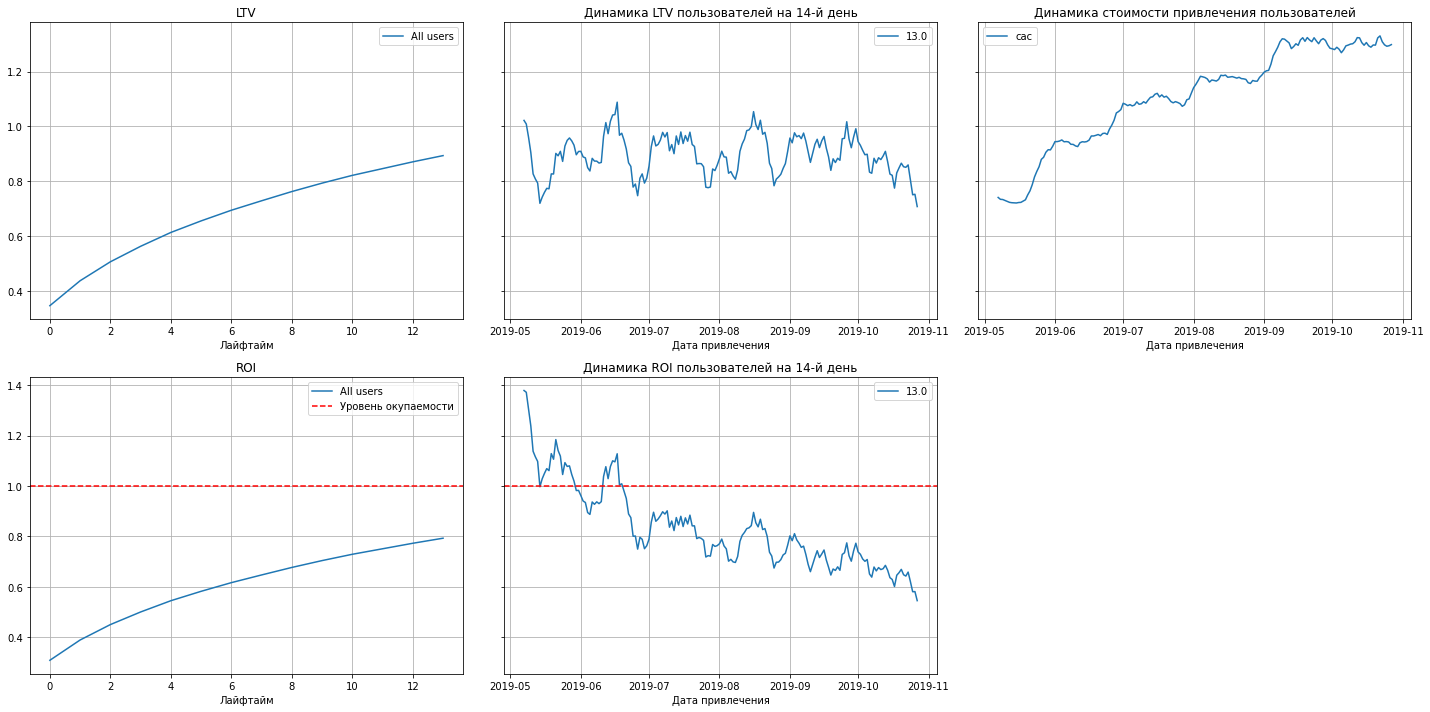

In [34]:
observation_date = datetime(2020, 11, 1).date()# задаем момент анализа

horizon_days = 14 # задаем горизонт анализа

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days) # вызвовем функции get_ltv() и plot_ltv_roi()

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- Реклама не окупается, ROI уровня окупаемости не достигает.

- С мая по сентябрь САС увеличивался, возможно, из-за вливаний в рекламный бюджет в октябре-ноябре показывает стабильность.

- LTV достаточно стабилен.

- До середины июля ROI еще был в зоне окупаемости, но после начал уверенно снижаться.

Проверим окупаемость с разбивкой по каналам привлечения.

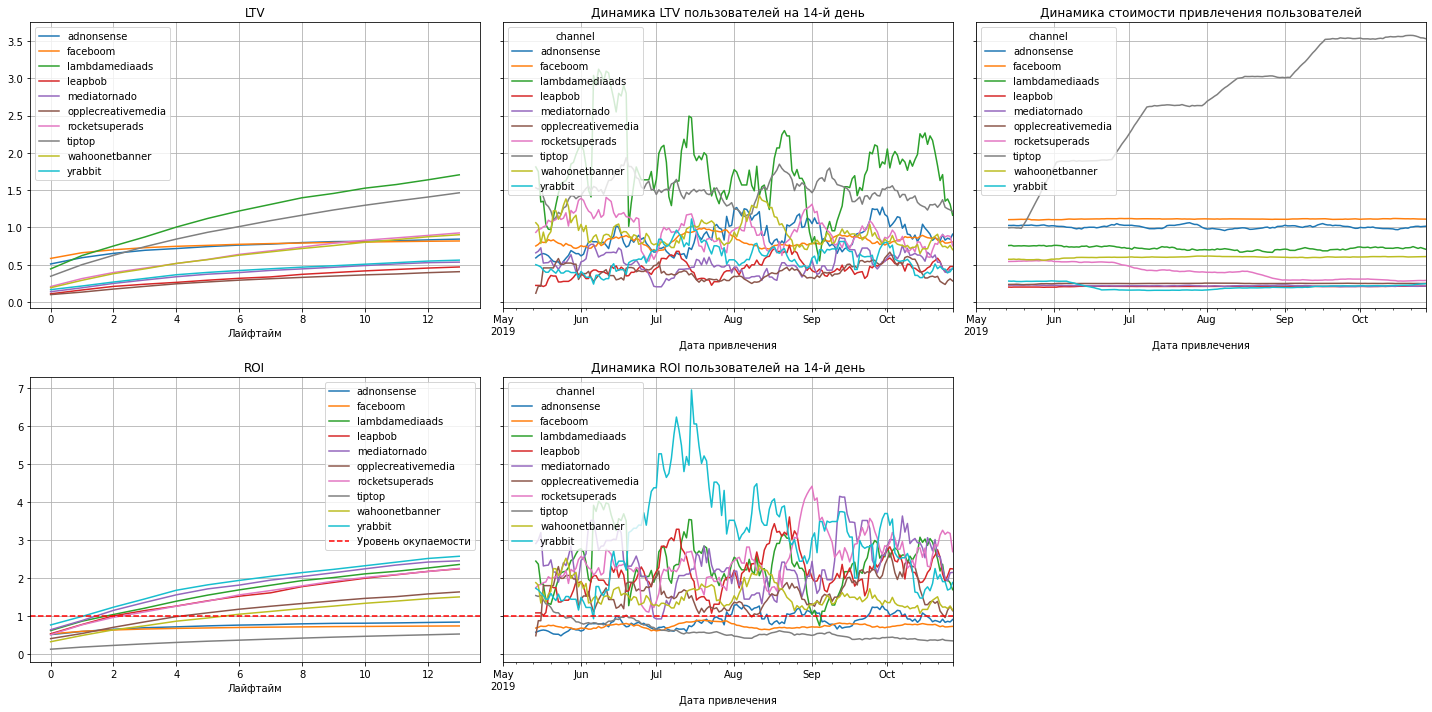

In [35]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

- По LTV лучше всех себя показали LambdaMediaAds и TipTop.

- По графику ROI можно сказать, что почти все рекламные каналы окупаются. Не дотягивают до уровня окупаемости только Faceboom, AdNonSense и TipTop. Лучше всех себя показывает Yrabbit.

- CAC пользователей из TipTop самый высокий и постоянно увеличивается. По остальным источникам есть незначительные колебания, но, в целом динамика САС показывает стабильность.

Проверим конверсию с разбивкой по каналам.

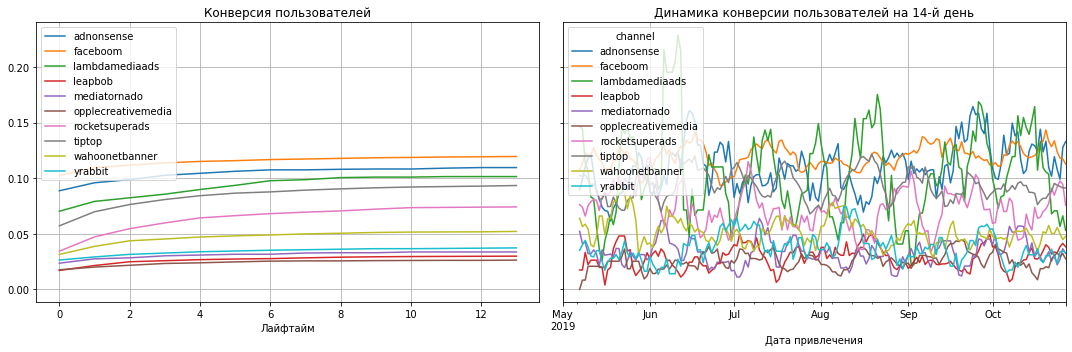

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия по каналам относительно стабильная, в лидерах FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

Посмотрим удержание с разбивкой по каналам.

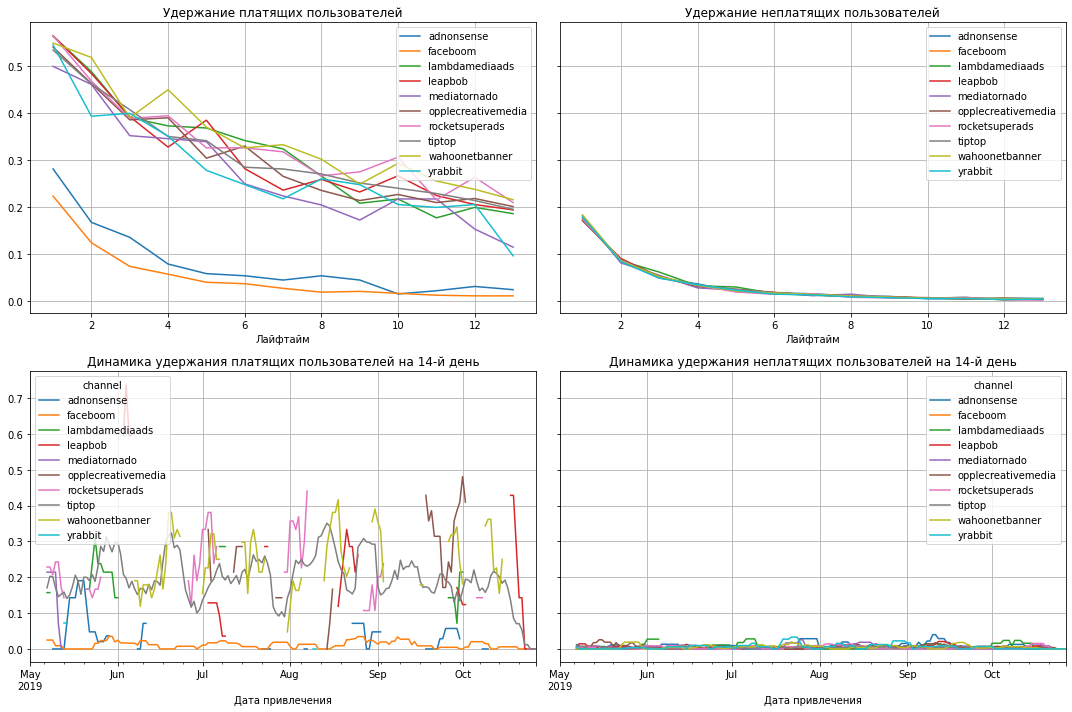

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Самое слабое удержание клиентов из рекламных площадок Faceboom и AdNonSense, по остальным площадкам ситуация стабильная.

Посмотрим окупаемость с разбивкой по странам.

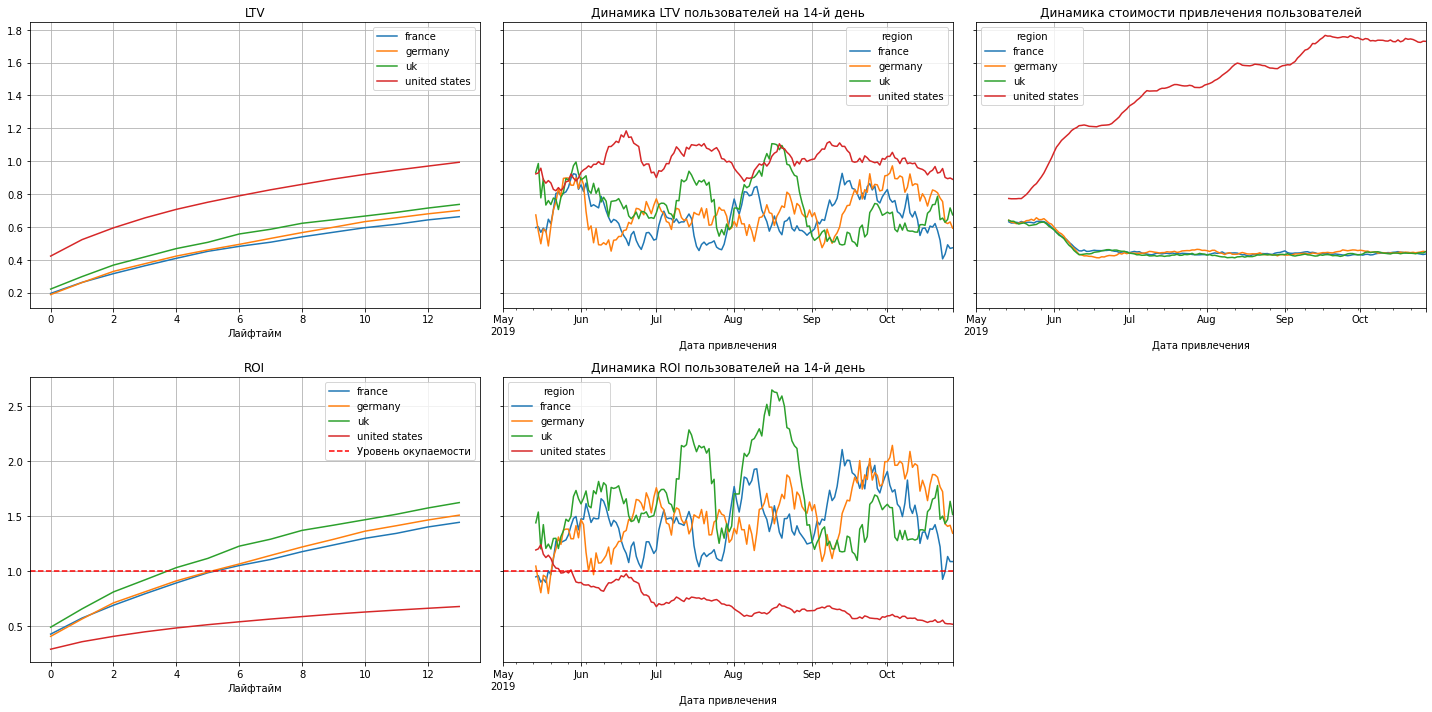

In [38]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама не окупается только в США. Именно там, где больше всего пользоваетелей и доля платящих из них. Падение ROI в США произошло в конце мая и, с тех пор, находится ниже уровня окупаемости. Лучше показатели у Великобритании.

В США наблюдается сильный рост САС, для остальных стран САС остается стабильным. 
LTV отностельно стабилен для всех стран. самый высокий LTV, опять же, у пользователей из США.

Посмотрим конверсию с разбивкой по странам.

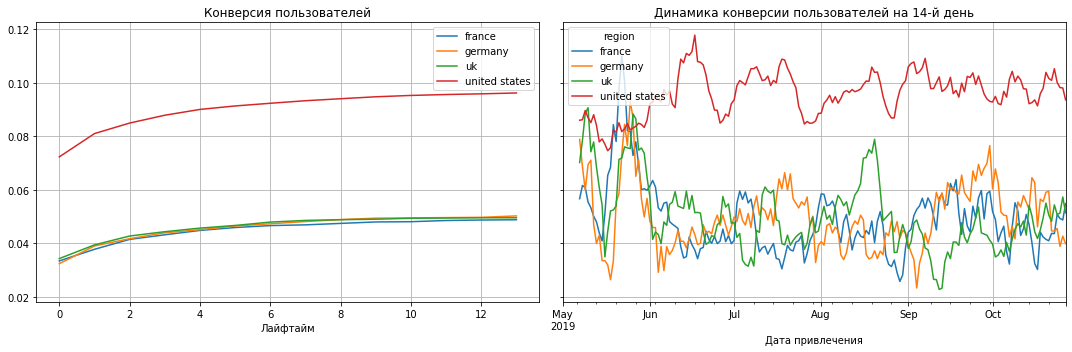

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия стабильна во всех странах. Самая высокая конверсия в США.

Посмотрим удержание с разбивкой по странам.

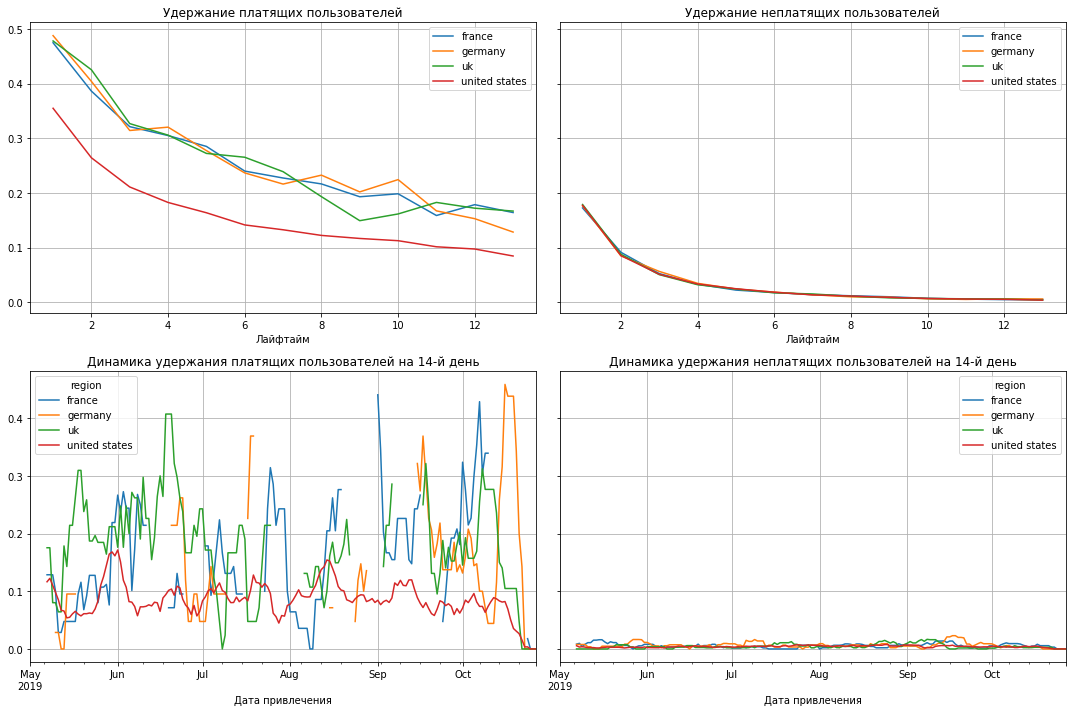

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Худшая динамика `CR` в США. В целом, показатель стабилен, без резких просадок. 

Посмотрим окупаемость с разбивкой по устройствам.

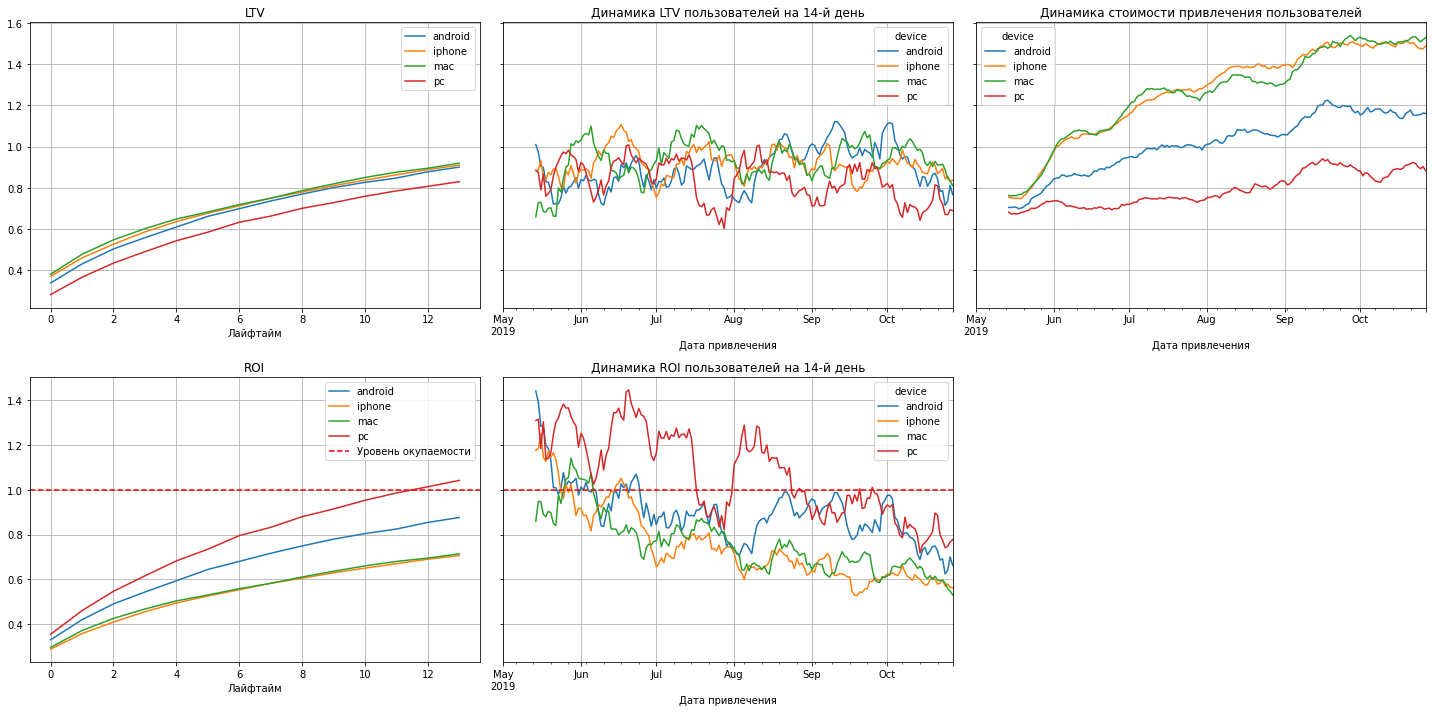

In [41]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

До уровня окупаемости смогли дотянуть только пользователи с ПК. Они же имеют наименьшую стоимость привлечения. Пользователи Mac и Iphone окупаются стабильно хуже всех. График динамики ROI пошел вниз, опять же, в начале июня.

Посмотрим конверсию с разбивкой по устройствам.

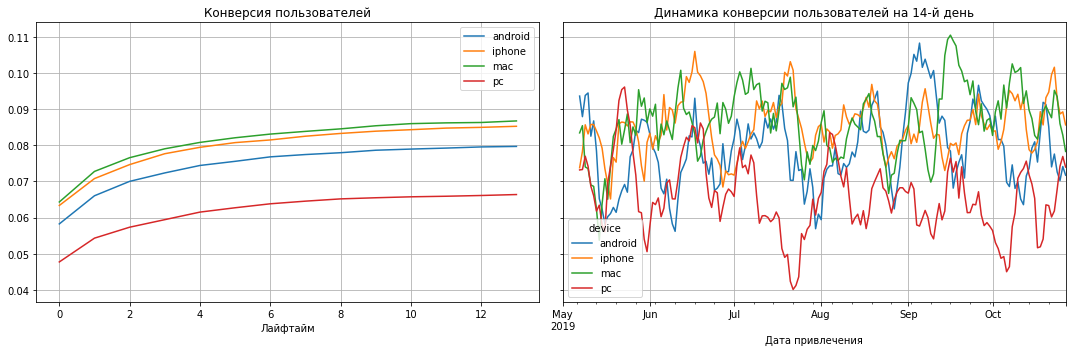

In [42]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия стабильная, для пользователей Mac и Iphone самая высокая, владельцы ПК имеют наименьшее желание оплачивать сервис.

Посмотрим удержание с разбивкой по устройствам

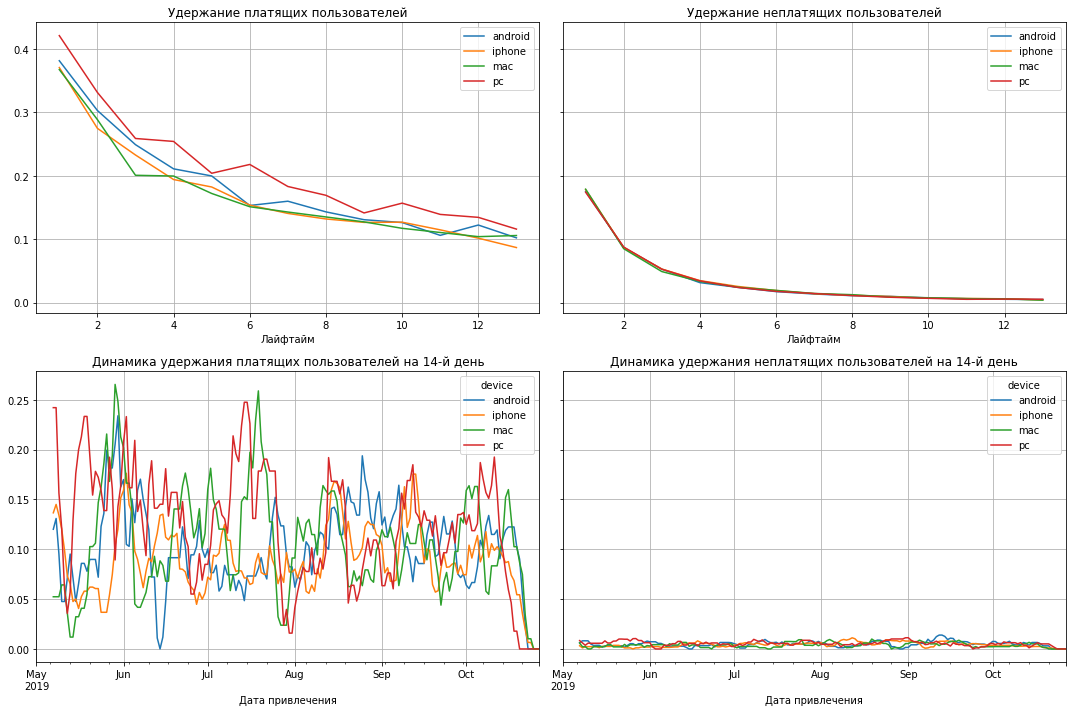

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержаение по устройствам стабильное, на 14-й день чуть выше 10%.

•	Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается, ROI уровня окупаемости не достигает.

•	Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Самую низкую окупаемость показывают пользователи Mac/Iphone, пользователи из США и клиенты приведенные Faceboom, AdNonSense и TipTop.

•	Чем могут быть вызваны проблемы окупаемости?

Какой-либо сезонности выявлено не было. Вероятно, проблемы возникли именно из-за клиентов из США, ведь они составляют наибольшую долю пользователей. Стоит рассмотреть вариант технических ошибок и сбоев сервиса, которые могли бы влиять на конкретный регион.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Мы проанализировали данные развлекательного приложения Procrastinate Pro+., провели предобработку данных, провели анализ бизнес-показателей как общий, так и с разбивкой по странам, устройствам и каналам привлечения клиентов. Построили графики бизнес-показателей.

Общая сумма расходов на рекламу составила:  105497.3

Основная масса клиентов приходит из США, меньше всего - из Германии.

Доля платящих пользователей в США также самая высокая.

Основная масса клиентов пользуется Iphone, меньше всего - Mac.

Доля платящих пользователей самая высокая среди владельцев Mac.

Больше всего пользователей пришли в приложение самостоятельно, без помощи рекламы. 

Среди рекламных площадок по кол-ву привлеченных клиентов первое место занимает Faceboom, последнее - LambdaMediaAds

Доля платящих пользователей самая высокая среди клиентов приведенных Faceboom.

Самая дорогая рекламная сеть - TipTop. Faceboom на втором месте

`САС` клиентов из TipTop самый высокий.

- Анализ рекламы

•	В целом реклама не окупается.
•	С мая по сентябрь `САС` увеличивался, возможно, из-за вливаний в рекламный бюджет в октябре-ноябре показывает стабильность.
•	LTV достаточно стабилен.
•	До середины июля `ROI` еще был в зоне окупаемости, но после начал уверенно снижаться.

По <b>рекламным каналам</b> показывают худшую окупаемость Faceboom, AdNonSense и TipTop. Лучшую - Yrabbit.

Самое слабое удержание клиентов из рекламных площадок Faceboom и AdNonSense.

В лидерах по конверсии FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

По <b>странам</b> реклама окупается везде, кроме США. Лучшие показатели у Великобритании.

В США наблюдается сильный рост `САС`

Наиболее высокий `LTV`и `CR` у пользователей из США, но динамика `CR` в США отрицательная.

По <b>устройствам</b> уровня окупаемости достигают только пользователи ПК с наименьшим `CAC`. Хуже всех окупаются пользователи Mac/Iphone.

Пользователи Mac/Iphone имеют лучший показатель конверсии.

# Рекомендации:
- Проверить целесообразность оплаты работы рекламной сети TipTop (вложения не оправдываются) и присмотреться к Yrabbit (лучшая окупаемость), RocketSuperAds и MediaTornado.
- Запросить информацию по техническим сбоям и ошибкам пользователей из США начиная с июня. 
- Обратить внимание на пользователей Iphone и Mac. У них наибольшая стоимость привлечения и худший возврат инвестиций. Возможно, стоит предложить какие-то акции и специальные условия.